In [1]:
# imports
import os
import time
import csv
import multiprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [2]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [3]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [4]:
set_seed(seed=2021)
set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


'cuda'

In [5]:
# hyper-parameters
use_cuda = torch.cuda.is_available()
alpha = 1  # alpha for mixup augmentation
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 128
end_apochs = 200  # Please change this to 200
base_learning_rate = 0.01
cutout = True  # True/False if you want to use cutout augmentation
mixup = False  # True/False if you want to use mixup augmentation
n_holes = 1  # number of holes to cut out from image for cutout
length = 8  # length of the holes for cutout augmentation
torchvision_transforms = False  # True/False if you want use torchvision augmentations

In [6]:
# @markdown `Cutout` Augmentation class

class Cutout(object):
    """
    code from: https://github.com/uoguelph-mlrg/Cutout
    
    Randomly mask out one or more patches from an image.
    Args:
      n_holes (int): Number of patches to cut out of each image.
      length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length
    
    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)
        
        mask = np.ones((h, w), np.float32)
    
        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            
            mask[y1: y2, x1: x2] = 0.
        
        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
    
        return img

In [7]:
# @markdown `mixup_data` Augmentation function

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda
      - https://github.com/hongyi-zhang/mixup
    '''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [8]:
# @markdown Download and prepare Data
print('==> Preparing data...')
def percentageSplit(full_dataset, percent=0.0):
    set1_size = int(percent * len(full_dataset))
    set2_size = len(full_dataset) - set1_size
    final_dataset, _ = torch.utils.data.random_split(full_dataset, [set1_size, set2_size])
    return final_dataset

# CIFAR100 normalizing
# mean = [0.5071, 0.4866, 0.4409]
# std = [0.2673, 0.2564, 0.2762]

# CIFAR10 normalizing
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

# torchvision transforms
transform_train = transforms.Compose([])
if torchvision_transforms:
    transform_train.transforms.append(transforms.RandomCrop(32, padding=4))
    transform_train.transforms.append(transforms.RandomHorizontalFlip())

transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

if cutout:
    transform_train.transforms.append(Cutout(n_holes=n_holes, length=length))

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform_train)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform_test)

==> Preparing data...
Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(f"Object type: {type(trainset)}")
print(f"Training data shape: {trainset.data.shape}")
print(f"Test data shape: {testset.data.shape}")
print(f"Number of classes: {np.unique(trainset.targets).shape[0]}")

Object type: <class 'torchvision.datasets.cifar.CIFAR10'>
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Number of classes: 10


In [10]:
# choose percentage from the trainset. set percent = 1.0 to use the whole train data
percent = 1.0
trainset = percentageSplit(trainset, percent = percent)
print(f"size of the new trainset: {len(trainset)}")

size of the new trainset: 50000


In [11]:
# Dataloader
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2)

----> number of workers: 96


In [12]:
# get batch of data
batch_X, batch_Y =  next(iter(trainloader))

In [13]:
def plot_mixed_images(images):
    inv_normalize = transforms.Normalize(
                      mean= [-m/s for m, s in zip(mean, std)],
                      std= [1/s for s in std]
                    )
    inv_PIL = transforms.ToPILImage()
    fig = plt.figure(figsize=(10, 8))
    
    for i in range(1, len(images) + 1):
        image = images[i-1]
        ax = fig.add_subplot(1, 4, i)
        inv_tensor = inv_normalize(image).cpu()
        ax.imshow(inv_PIL(inv_tensor))
        
    plt.show()

In [14]:
# Mixup Visualization
if mixup:
  alpha = 0.9
  mixed_x, y_a, y_b, lam = mixup_data(batch_X.cuda(), batch_Y.cuda(), alpha=alpha, use_cuda=use_cuda)
  plot_mixed_images(mixed_x[:4])

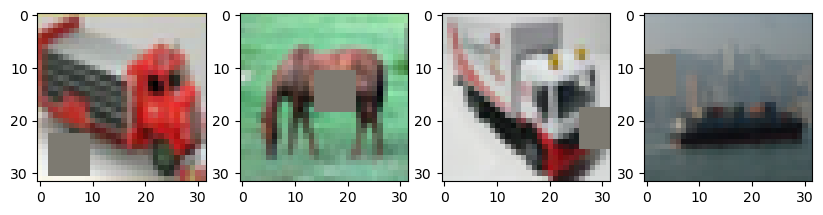

In [15]:
# Mixup Visualization
if cutout:
  plot_mixed_images(batch_X[:4])

In [16]:
# @markdown ResNet model in PyTorch

class Bottleneck(nn.Module):
    """
    For deep networks, we use BottleNeck, which is proposed in the paper to have approximate computational complexity but save a lot of resources
    zip_channels: The compressed dimension, the final output dimension is expansion * zip_channels
    For the network structure of ResNet50/101/152, mainly because the third layer is 4 times the second layer, so expansion=4
    """
    expansion = 4

    def __init__(self, in_channels, zip_channels, stride=1):
        super(Bottleneck, self).__init__()
        out_channels = self.expansion * zip_channels
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, zip_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, zip_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(zip_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(zip_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out

class BasicBlock(nn.Module):
    """
    For shallow networks, such as ResNet-18/34, etc., use the basic Block
    The base module is not compressed, so expansion=1
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
            nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        # If the input and output dimensions are not equal, use a 1x1 convolutional layer to change the dimension
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x)
# print(out.shape)
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


class ResNet(nn.Module):
    """
    Different ResNet architectures are unified with one layer of feature extraction and four layers of residuals, and the difference lies in the depth of each layer of residuals.
    For cifar10, the change of feature map size is as follows:
    (32, 32, 3) -> [Conv2d] -> (32, 32, 64) -> [Res1] -> (32, 32, 64) -> [Res2]
 -> (16, 16, 128) -> [Res3] -> (8, 8, 256) ->[Res4] -> (4, 4, 512) -> [AvgPool]
 -> (1, 1, 512) -> [Reshape] -> (512) -> [Linear] -> (10)
    """
    def __init__(self, block, num_blocks, num_classes=10, verbose = False):
        super(ResNet, self).__init__()
        self.verbose = verbose
        self.in_channels = 64
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        #Use the _make_layer function to generate the structure of conv2_x, conv3_x, conv4_x, conv5_x corresponding to the above table
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # After cifar10 goes through the above structure, the feature map size here is 4 x 4 x 512 x expansion
        # So 4 x 4 average pooling is used here
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 *block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        # The first block needs to be downsampled
        strides = [stride] + [1]* (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            # If it is Bottleneck Block, you need to compress the input dimension of each layer, and then increase the dimension after compression
            # So the input dimension of each layer should also change accordingly
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out


def ResNet18(verbose=False):
    return ResNet(BasicBlock, [2,2,2,2],verbose=verbose)

def ResNet34(verbose=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose)

def ResNet50(verbose=False):
    return ResNet(Bottleneck, [3,4,6,3],verbose=verbose)

def ResNet101(verbose=False):
    return ResNet(Bottleneck, [3,4,23,3],verbose=verbose)

def ResNet152(verbose=False):
    return ResNet(Bottleneck, [3,8,36,3],verbose=verbose)

In [17]:
# load the Model
net = ResNet18()
print('-----> verify if model is run on random data')
y = net(Variable(torch.randn(1,3,32,32)))
print('model loaded')

result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

proc = "{}{}".format("cutout" if cutout else "", "mixup" if mixup else "") 

logname = result_folder + net.__class__.__name__ + '_' +proc+ '_size8.csv'

if use_cuda:
  net.cuda()
  net = torch.nn.DataParallel(net)
  print('Using', torch.cuda.device_count(), 'GPUs.')
  cudnn.benchmark = True
  print('Using CUDA..')

-----> verify if model is run on random data
model loaded
Using 1 GPUs.
Using CUDA..


In [18]:
# optimizer and criterion

def mixup_criterion(y_a, y_b, lam):
  '''
    - Mixup criterion
    - https://github.com/hongyi-zhang/mixup
  '''
  return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=base_learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, min_lr=1e-5)

In [19]:
# Training & Test functions
def train(epoch, alpha, use_cuda=False):
    print('\nEpoch: %d' % epoch)
    
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):

        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        if mixup:
        # generate mixed inputs, two one-hot label vectors and mixing coefficient
            inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha, use_cuda)
            inputs, targets_a, targets_b = Variable(inputs), Variable(targets_a), Variable(targets_b)
            outputs = net(inputs)
            loss_func = mixup_criterion(targets_a, targets_b, lam)
            loss = loss_func(criterion, outputs)
        else:
            inputs, targets = Variable(inputs), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)

        if mixup:
            correct += lam * predicted.eq(targets_a.data).cpu().sum() + (1 - lam) * predicted.eq(targets_b.data).cpu().sum()
            # correct += lam * predicted.eq(targets_a.data).sum() + (1 - lam) * predicted.eq(targets_b.data).sum()
        else:
            correct += predicted.eq(targets.data).cpu().sum()
            # correct += predicted.eq(targets.data).sum()

        acc = 100.*(correct/total)
        
        if batch_idx % 500 == 0:
            print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), acc, correct, total))
        

    return (train_loss/batch_idx, acc)


In [20]:
def test(epoch, use_cuda=False):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            if use_cuda:
                inputs, targets = inputs.cuda(), targets.cuda()
            # inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            # correct += predicted.eq(targets.data).sum()
            

            if batch_idx % 200 == 0:
                print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*(correct/total)
    
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)
    return (test_loss/batch_idx, acc)

In [21]:
# @markdown `checkpoint` and `adjust_learning_rate` functions
def checkpoint(acc, epoch):
  # Save checkpoint.
  print('Saving..')
  state = {
      'net': net.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
      }
  if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
  torch.save(state, './checkpoint/ckpt.t7')


def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [22]:
# start training
if not os.path.exists(logname):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['epoch', 'train loss', 'train acc',
                        'test loss', 'test acc'])

for epoch in range(start_epoch+1, end_apochs+1):
#   adjust_learning_rate(optimizer, epoch)
    start = time.time()

    train_loss, train_acc = train(epoch, alpha, use_cuda=use_cuda)
    test_loss, test_acc = test(epoch, use_cuda=use_cuda)

    scheduler.step(test_loss)

    end = time.time()

    time_ = int(end - start)
    h = time_ / 3600
    m = time_ % 3600 /60
    s = time_ % 60
    time_str = "%02d:%02d" % ( m, s)


    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, train_acc.item(),test_loss, test_acc.item()])
        
    print(f"Epoch: {epoch} | Time Per Epoch: {time_str} | train acc: {train_acc:.2f} | test acc: {test_acc:.2f}% | Learning Rate: {optimizer.param_groups[0]['lr']}")


Epoch: 1


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


0 391 Loss: 2.454 | Acc: 10.156% (13/128)
0 79 Loss: 1.639 | Acc: 45.312% (58/128)
Saving..
Epoch: 1 | Time Per Epoch: 00:39 | train acc: 32.93 | test acc: 41.14% | Learning Rate: 0.01

Epoch: 2
0 391 Loss: 1.554 | Acc: 42.969% (55/128)
0 79 Loss: 1.605 | Acc: 43.750% (56/128)
Epoch: 2 | Time Per Epoch: 00:32 | train acc: 47.64 | test acc: 40.50% | Learning Rate: 0.01

Epoch: 3
0 391 Loss: 1.236 | Acc: 57.031% (73/128)
0 79 Loss: 1.292 | Acc: 51.562% (66/128)
Saving..
Epoch: 3 | Time Per Epoch: 00:31 | train acc: 54.85 | test acc: 55.82% | Learning Rate: 0.01

Epoch: 4
0 391 Loss: 1.069 | Acc: 60.938% (78/128)
0 79 Loss: 1.487 | Acc: 50.000% (64/128)
Epoch: 4 | Time Per Epoch: 00:32 | train acc: 59.07 | test acc: 49.61% | Learning Rate: 0.01

Epoch: 5
0 391 Loss: 1.094 | Acc: 57.031% (73/128)
0 79 Loss: 1.028 | Acc: 64.844% (83/128)
Saving..
Epoch: 5 | Time Per Epoch: 00:51 | train acc: 61.57 | test acc: 61.92% | Learning Rate: 0.01

Epoch: 6
0 391 Loss: 1.015 | Acc: 67.969% (87/128)
0

In [23]:
# plot results
results = pd.read_csv(logname, sep=',')
results.head()

,epoch,train loss,train acc,test loss,test acc
0,1,1.838753,32.925999,1.617530,41.139999
1,2,1.425040,47.644001,1.718185,40.500000
2,3,1.240666,54.847996,1.258132,55.820000
3,4,1.133274,59.074001,1.490818,49.610001
4,5,1.072921,61.566002,1.072360,61.919998


In [24]:
train_accuracy = results['train acc'].values
test_accuracy = results['test acc'].values

print(f"Average test Accuracy over {end_apochs} epochs: {sum(test_accuracy)//len(test_accuracy)}")
print(f"best test accuraccy over {end_apochs} epochs: {max(test_accuracy)}")

Average test Accuracy over 200 epochs: 76.0
best test accuraccy over 200 epochs: 80.79000091552734


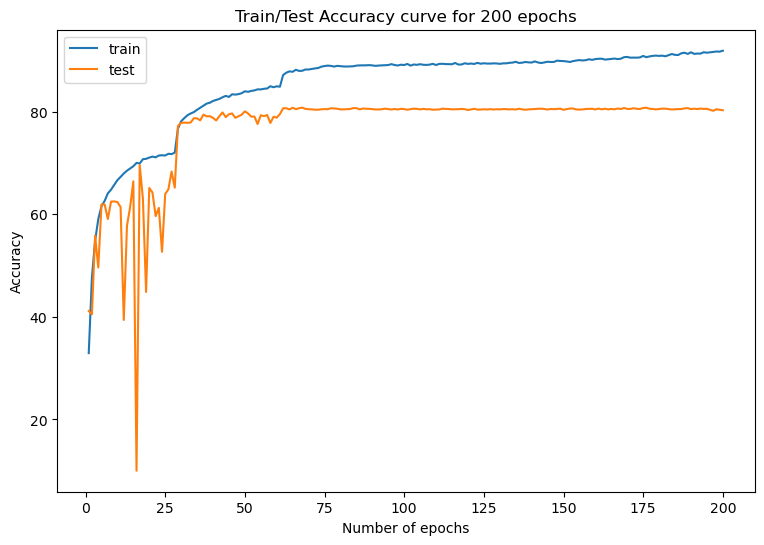

In [25]:
plt.figure(figsize=(9, 6))
plt.plot(sorted(results['epoch'].values), train_accuracy, label='train')
plt.plot(sorted(results['epoch'].values), test_accuracy, label='test')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title(f'Train/Test Accuracy curve for {end_apochs} epochs')
plt.legend()
plt.show()